In [1]:
import sympy as sym
import numpy as np
from sympy import lambdify
import matplotlib.tri as tri
from matplotlib.colors import BoundaryNorm
import matplotlib.colors as mcolors
from archive.plotting_utils import *
import pandas as pd
import torch
import torch.nn as nn
import joblib
import time
import pickle

# Define functions, tensors, grid

In [2]:
# Define symbols
x1, x2 = sym.Symbol('x1'), sym.Symbol('x2')  # Spatial variables
mu, alpha = sym.Symbol('mu'), sym.Symbol('alpha')  # Material properties
a, b = sym.Symbol('a'), sym.Symbol('b')  # Deformation parameters
sigma_y, h = sym.Symbol('sigma_y'), sym.Symbol('h')  # Yield stress and hardening parameter

In [3]:
# Deformation functions
u1=a*x1*x1*x2
u2=b*x2*x1
lam_u1 = lambdify([x1,x2,a], u1, "numpy")
lam_u2 = lambdify([x1,x2,b], u2, "numpy")

In [4]:
# Deformation gradient and strain tensors
uGrad=sym.Matrix([
                [sym.diff(u1, x1, 1), sym.diff(u2, x1, 1)],
                [sym.diff(u1, x2, 1),sym.diff(u2, x2, 1)]]
                )
uEps=(uGrad + uGrad.transpose()) / 2
uEpsTrace=sym.Trace(uEps).simplify()

In [5]:
# Stress tensor (A)
A = 2 * mu * uEps + alpha * uEpsTrace * sym.eye(2)

In [6]:
# Grid definition
x1_min = 0
x1_max = 2
x2_min = 0
x2_max = 1
N1 = 900
N2 = x2_max * N1 // x1_max

In [7]:
x1_grid = np.linspace(x1_min, x1_max, N1, endpoint=True)
x2_grid = np.linspace(x2_min, x2_max, N2, endpoint=True)
X1 = np.tile(x1_grid.reshape(1, N1), (N2, 1))
X2 = np.tile(x2_grid.reshape(N2, 1), (1, N1))

In [8]:
# Deformation parameters
mu_val = 80e9
alpha_val = 121e9
sigma_y_val = 400e8
h_val = 50
a_val = 0.5
b_val = 0.25
a_val, b_val

(0.5, 0.25)

In [9]:
# Evaluate displacement functions
U1 = lam_u1(X1, X2, a_val)
U2 = lam_u2(X1, X2, b_val)

In [10]:
# Deviatoric part and Frobenius norm
dev_A = A - (A.trace() / 2) * sym.eye(2)  # Deviator A
norm_dev_A = dev_A.norm("fro")

In [11]:
# P
small_eps = sym.S(1e-12)  # small number to avoid division by 0

P = (sym.Max(norm_dev_A - sigma_y, 0) / (2 * mu + h)) * (dev_A / (norm_dev_A + small_eps))

In [12]:
# Lambdify to create functions
lam_A = sym.lambdify([x1, x2, mu, alpha, a, b], A, "numpy")  # Function for A
lam_dev_A = sym.lambdify([x1, x2, mu, alpha, a, b], dev_A, "numpy")  # Function for dev A
lam_P = sym.lambdify([x1, x2, mu, alpha, a, b, sigma_y, h], P, "numpy")  # Function for P

In [13]:
# Calculate A & P norms
norms_A_grid = np.zeros_like(X1)
norms_P_grid = np.zeros_like(X1)
indicator_norm_P = np.zeros_like(X1)  # 1 if norm > 0 otherwise 0
norm_dev_A_grid = np.zeros_like(X1)
for i in range(X1.shape[0]):  # iterate through the grid
    for j in range(X1.shape[1]):
        x1_val = X1[i, j]
        x2_val = X2[i, j]

        # A & P for current point
        A = lam_A(x1_val, x2_val, mu_val, alpha_val, a_val, b_val)
        P = lam_P(x1_val, x2_val, mu_val, alpha_val, a_val, b_val, sigma_y_val, h_val)
        # Frobenius norm
        norms_A_grid[i, j] = np.linalg.norm(A, ord='fro')
        norms_P_grid[i, j] = np.linalg.norm(P, ord='fro')
        # Compute the deviator of A
        dev_A = A - (np.trace(A) / 2) * np.eye(2)  # Deviator is A minus its isotropic part
        norm_dev_A_grid[i, j] = np.linalg.norm(dev_A, ord='fro')  # Frobenius norm of the deviator

        indicator_norm_P[i, j] = 1 if norms_P_grid[i, j] > 0 else 0

# Plot deformation, grid and norms

## Non-deformed grid

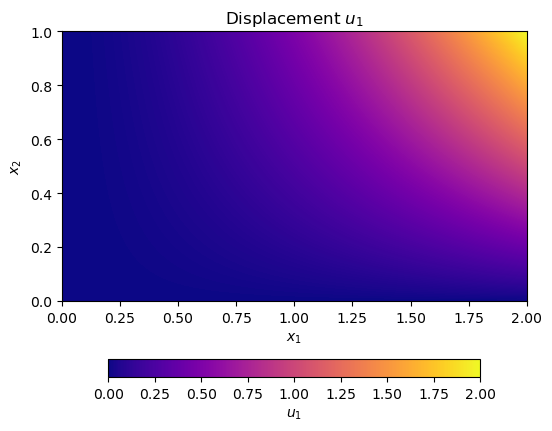

In [14]:
# Plot the results
plt.figure(figsize=(6, 5))
plt.title("Displacement $u_1$")
plt.imshow(U1, extent=(x1_min, x1_max, x2_min, x2_max), origin='lower', aspect='auto', cmap='plasma')

# Add a horizontal colorbar at the bottom
cbar = plt.colorbar(label="$u_1$", orientation='horizontal', pad=0.15, shrink = 0.8)  # `pad` regulates distance to graph

# Add labels and save
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
#plt.savefig('../images/single-yield/Displacement_U1.png', format='png', dpi = 300, bbox_inches='tight')  # uncomment/comment to save/not to save
plt.show()

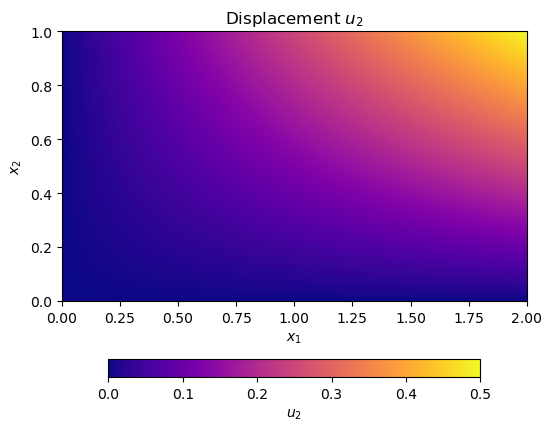

In [15]:
plt.figure(figsize=(6, 5))
plt.title("Displacement $u_2$")
plt.imshow(U2, extent=(x1_min, x1_max, x2_min, x2_max), origin='lower', aspect='auto', cmap='plasma')
# Add a horizontal colorbar at the bottom
cbar = plt.colorbar(label="$u_2$", orientation='horizontal', pad=0.15, shrink = 0.8)  # `pad` regulates distance to graph

plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
#plt.savefig('../images/single-yield/Displacement_U2.png', format='png', dpi = 300, bbox_inches='tight')  # uncomment/comment to save/not to save
plt.show()

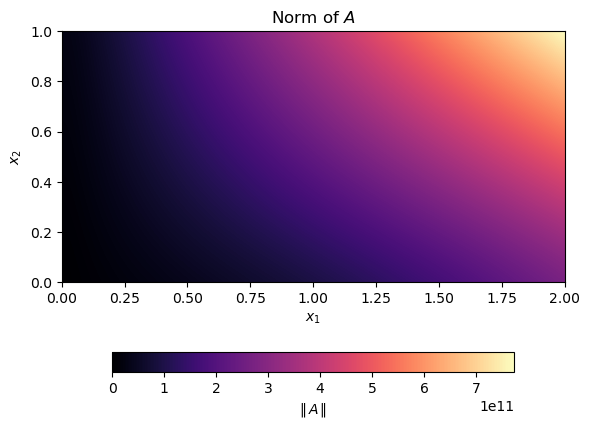

In [16]:
# Plot norm of A
plt.figure(figsize=(6, 5))
plt.title("Norm of $A$")
plt.imshow(norms_A_grid, extent=(x1_min, x1_max, x2_min, x2_max), origin='lower', cmap='magma')
cbar = plt.colorbar(label=r"$\|\,A\,\|$", orientation='horizontal', pad=0.15, shrink = 0.8)
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.tight_layout()
#plt.savefig("../images/single-yield/norm_A.png", format='png', dpi = 300, bbox_inches = 'tight')  # uncomment/comment to save/not to save
plt.show()

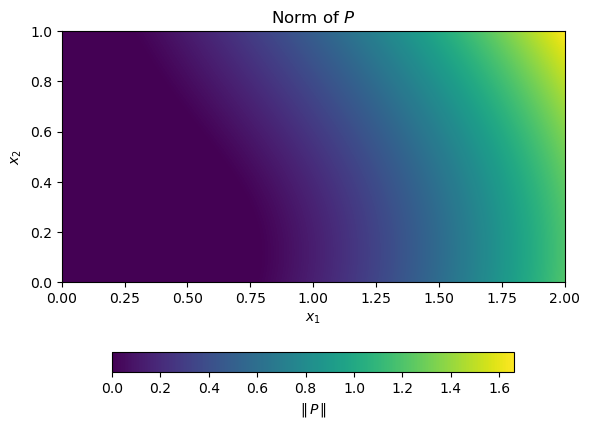

In [17]:
# Plot norm of P
plt.figure(figsize=(6, 5))
plt.title("Norm of $P$")
plt.imshow(norms_P_grid, extent=(x1_min, x1_max, x2_min, x2_max), origin='lower', cmap='viridis')
cbar = plt.colorbar(label=r"$\|\,P\,\|$", orientation='horizontal', pad=0.15, shrink = 0.8)
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.tight_layout()
#plt.savefig("../images/single-yield/norm_P.png", format='png', dpi = 300, bbox_inches = 'tight')  # uncomment/comment to save/not to save
plt.show()

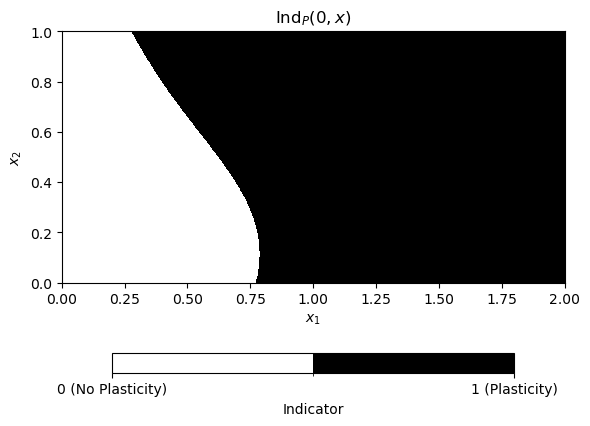

In [18]:
# Plot indicator norm of P
# Create a discrete colormap: white for 0, black for 1
cmap = mcolors.ListedColormap(["white", "black"])
bounds = [0, 0.5, 1]  # Boundary values to separate 0 and 1
norm = mcolors.BoundaryNorm(bounds, cmap.N)

plt.figure(figsize=(6, 5))
plt.title(r"$\mathrm{Ind}_P(0, x)$")

# IMPORTANT: save the result of imshow to 'im1'
im1 = plt.imshow(
    indicator_norm_P,
    extent=(x1_min, x1_max, x2_min, x2_max),
    origin='lower',
    cmap=cmap,
    norm=norm
)

# Axis labels
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")

cbar = plt.colorbar(im1, orientation='horizontal', pad=0.15, ticks=[0, 1], shrink=0.8)
cbar.ax.set_xticklabels(["0 (No Plasticity)", "1 (Plasticity)"])
cbar.set_label("Indicator")

# Adjust layout
plt.tight_layout()

# Save and show
#plt.savefig("../images/single-yield/indicator_norm_P.png", format='png', dpi = 300, bbox_inches='tight')  # uncomment/comment to save/not to save
plt.show()

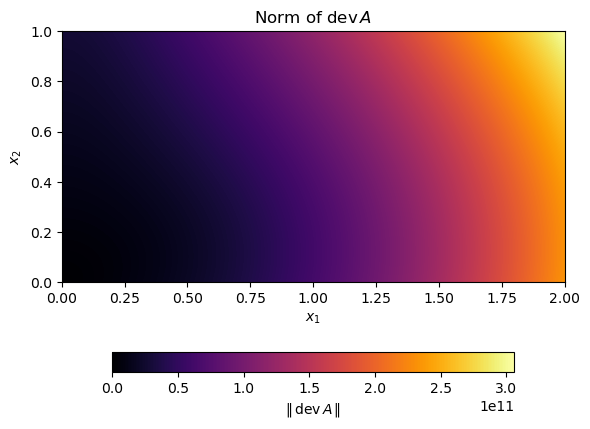

In [19]:
# Plot norm of the deviator of A
plt.figure(figsize=(6, 5))
plt.title(r"Norm of $\text{dev}\,A$")
plt.imshow(norm_dev_A_grid, extent=(x1_min, x1_max, x2_min, x2_max), origin='lower', cmap='inferno')
cbar = plt.colorbar(label=r"$\|\,\text{dev}\,A\,\|$", orientation='horizontal', pad=0.15, shrink = 0.8)
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.tight_layout()
#plt.savefig("../images/single-yield/norm_dev_A.png", format='png', dpi = 300, bbox_inches = 'tight')  # uncomment/comment to save/not to save
plt.show()

## Deformed grid

In [14]:
ampl = 1

Y1 = (X1 + ampl * U1)
Y2 = (X2 + ampl * U2)

In [15]:
# Flatten the grid
points_x = Y1.flatten()
points_y = Y2.flatten()

In [16]:
# Create triangulation
triangles = tri.Triangulation(points_x, points_y)

In [17]:
p_flat = norms_P_grid.flatten()
ind_flat = indicator_norm_P.flatten()

In [18]:
# compute one indicator per triangle:
# e.g. if any of the triangle's vertices is plastic (==1), mark the whole triangle 1
tri_inds = (ind_flat[triangles.triangles].sum(axis=1) > 0).astype(int)
# p_flat is shape (n_points,) giving ||P|| at each vertex
# triang.triangles is shape (n_triangles, 3)
p_tri = p_flat[triangles.triangles].mean(axis=1)

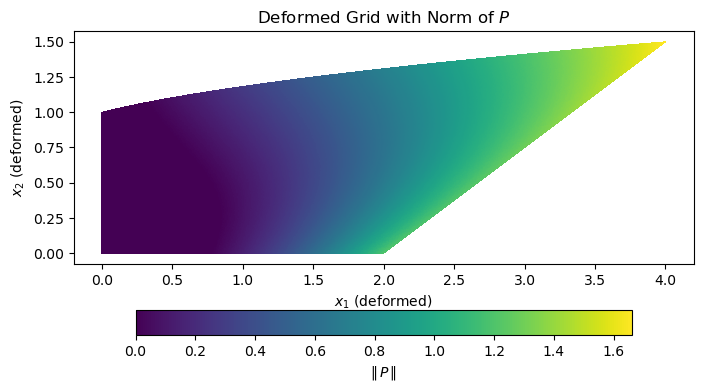

In [19]:
 # Plotting with color mapping
plt.figure(figsize=(8, 6))
plt.tripcolor(triangles, facecolors=p_tri, cmap='viridis')
plt.triplot(triangles, color='black', alpha=0, linewidth=0)
cbar = plt.colorbar(label=r"$\|\,P\,\|$", orientation='horizontal', pad=0.1, shrink=0.8)
plt.gca().set_aspect('equal', adjustable='box')
plt.title("Deformed Grid with Norm of $P$")
plt.xlabel("$x_1$ (deformed)")
plt.ylabel("$x_2$ (deformed)")
plt.savefig('../images/single-yield/Deformation_Grid_Visualization_with_Norms_of_P.png', format='png', dpi = 300, bbox_inches='tight')  # uncomment/comment to save/not to save
plt.show()

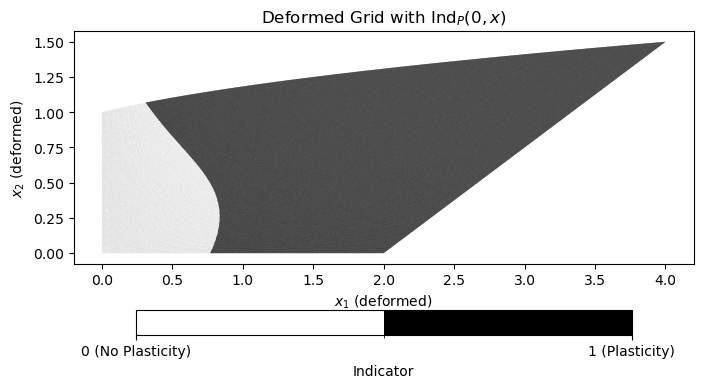

In [21]:
plt.figure(figsize=(8, 6))
cmap = mcolors.ListedColormap(["white", "black"])
bounds = [0, 0.5, 1]
norm = mcolors.BoundaryNorm(bounds, cmap.N)
plt.tripcolor(triangles, facecolors=tri_inds, cmap=cmap, norm=norm, edgecolors='black', linewidth=0.001)
plt.gca().set_aspect('equal', adjustable='box')  # Aspect ratio
plt.xlabel("$x_1$ (deformed)")
plt.ylabel("$x_2$ (deformed)")
plt.title(r"Deformed Grid with $\mathrm{Ind}_P(0, x)$")

cbar = plt.colorbar(orientation='horizontal', pad=0.1, ticks=[0, 1], shrink=0.8)
cbar.ax.set_xticklabels(["0 (No Plasticity)", "1 (Plasticity)"])
cbar.set_label("Indicator")

plt.savefig('../images/single-yield/Deformation_Grid_Indicator_Norms_of_P.png', format='png', dpi = 300, bbox_inches='tight')  # uncomment/comment to save/not to save
plt.show()

# Create data for training

In [27]:
# Initialize lists to store data
data = []

# Iterate through the grid and save A and P matrices
for i in range(X1.shape[0]):  # iterate through the grid
    for j in range(X1.shape[1]):
        x1_val = X1[i, j]
        x2_val = X2[i, j]

        # A & P for current point
        A = lam_A(x1_val, x2_val, mu_val, alpha_val, a_val, b_val)
        P = lam_P(x1_val, x2_val, mu_val, alpha_val, a_val, b_val, sigma_y_val, h_val)

        # Save A and P values
        row = A.flatten().tolist() + P.flatten().tolist()
        data.append(row)

In [28]:
# Create column names
columns = ['$A_{00}$', '$A_{01}$', '$A_{10}$', '$A_{11}$'] + ['$P_{00}$', '$P_{01}$', '$P_{10}$', '$P_{11}$']

# Create a DataFrame
df = pd.DataFrame(data, columns=columns)

# Save to CSV
csv_filename = "../data/single-yield_training_data.csv"
df.to_csv(csv_filename, index=False)

print(f"Data saved to {csv_filename}")

Data saved to A_P_matrices_bigger_data.csv


In [29]:
print(df.shape)

(405000, 8)


# Using Neural Network

In [13]:
class DynamicMLP(nn.Module):
    """
    Multilayer perceptron (MLP) with dynamic layer configuration and optional Dropout regularisation.

    This class allows the creation of MLPs with an arbitrary number of layers and neurons, and with the ability to
    adding Dropout between layers to prevent overtraining.

    Args:
        layers (list): A list containing the number of neurons in each layer. The length of the list determines
                       the number of layers; the list values are the number of neurons in each corresponding layer.
        dropout_rate (float, optional): The probability of neurons in Dropout layers being switched off.
                                        The default is 0, which means no Dropout.
    """
    def __init__(self, layers, dropout_rate=0):
        super(DynamicMLP, self).__init__()
        self.layers = nn.ModuleList()
        self.dropout_rate = dropout_rate

        for i in range(len(layers) - 1):
            self.layers.append(nn.Linear(layers[i], layers[i + 1]))
            if i < len(layers) - 2:  # no activation function after last layer
                self.layers.append(nn.ReLU())  # Reduced linear unit
                if self.dropout_rate != 0:
                    self.layers.append(nn.Dropout(self.dropout_rate))

    def forward(self, x):
        """
        Forward pass of the MLP model.

        This method propagates the input `x` through the network layers, applying
        linear transformations, ReLU activations (except for the last layer), and
        optional dropout regularization.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, input_dim).

        Returns:
            torch.Tensor: Output tensor of shape (batch_size, output_dim).
        """
        x = x.flatten(start_dim=1)
        for layer in self.layers:
            x = layer(x)
        return x

In [14]:
with open("best_model_overall_bigger_data.pkl", "rb") as f:
    saved_data = pickle.load(f)
model_state = saved_data["model_state"]
best_config = saved_data["config"]

model = DynamicMLP(best_config["layers"], dropout_rate=best_config["dropout"])
model.load_state_dict(model_state)

print("Loaded configuration:", best_config)

Loaded configuration: {'layers': [3, 512, 256, 128, 2], 'dropout': 0, 'optimizer': 'adam', 'lr': 0.001, 'weight_decay': 0.0001, 'delta': 0.5, 'val_loss': 7.870974727426354e-05}


In [15]:
def process_in_batches(data, model, batch_size=10000, device=None):
    """
    Processes large input data in batches through the neural network.

    This function efficiently processes large datasets by splitting them into smaller
    batches and passing them through the given neural network model. It automatically
    detects and utilizes the available computing device (CPU/GPU) to optimize performance.

    Args:
        data (numpy.ndarray): A 2D array of input features, where each row is a sample.
        model (torch.nn.Module): A trained PyTorch neural network model.
        batch_size (int, optional): The number of samples processed in a single batch
                                    (default: 10000). Larger batch sizes may improve
                                    performance but require more memory.
        device (str or torch.device, optional): a computing device, e.g. "cpu" or "cuda".
                                                By default, it is automatically selected.

    Returns:
        numpy.ndarray: A 2D array of model predictions, with the same number of rows as `data`.
                       The predictions are computed in batches and concatenated to form
                       the final output.

    Notes:
        - The function automatically transfers the model and input data to the available
          computing device (GPU if available, otherwise CPU).
        - The model is set to evaluation mode (`model.eval()`) to ensure that dropout and
          batch normalization layers (if present) behave consistently.
        - Computation is performed without tracking gradients (`torch.no_grad()`)
          to reduce memory usage and improve inference speed.
    """
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    else:
        device = torch.device(device)
    model.to(device)  # Move model to the appropriate device
    model.eval()  # Set model to evaluation mode

    num_samples = data.shape[0]
    results = []

    for i in range(0, num_samples, batch_size):
        batch = torch.tensor(data[i:i + batch_size], dtype=torch.float32).to(device)  # Move batch to device
        with torch.no_grad():
            batch_result = model(batch).cpu().numpy()  # Compute predictions and move back to CPU
        results.append(batch_result)

    return np.vstack(results)  # Concatenate all batch results into a single output array


In [16]:
# Load scaler
scaler_A = joblib.load('scaler_A.pkl')
scaler_P = joblib.load('scaler_P.pkl')

# Test grid comparisom

## Non-deformed grid

In [78]:
# bigger grid definition
x1_min = 0
x1_max = 2
x2_min = 0
x2_max = 1
N1 = 600
N2 = x2_max * N1 // x1_max

In [79]:
x1_grid = np.linspace(x1_min, x1_max, N1, endpoint=True)
x2_grid = np.linspace(x2_min, x2_max, N2, endpoint=True)
X1 = np.tile(x1_grid.reshape(1, N1), (N2, 1))
X2 = np.tile(x2_grid.reshape(N2, 1), (1, N1))

In [80]:
# Flatten X1 and X2 to prepare for batch computation
x1_vals = X1.flatten()
x2_vals = X2.flatten()

In [81]:
# Evaluate displacement functions
U1 = lam_u1(X1, X2, a_val)
U2 = lam_u2(X1, X2, b_val)

In [72]:
# -------------------------
# Method 1: Using Formula
# -------------------------
# Measure time for formula-based computation
start_formula = time.time()

# Compute P for all points in the grid
P_formula = np.array([lam_P(x1, x2, mu_val, alpha_val, a_val, b_val, sigma_y_val, h_val) for x1, x2 in zip(x1_vals, x2_vals)])

time_formula = time.time() - start_formula

# Compute norms and indicators for formula-based results
norms_P_grid = np.array([np.linalg.norm(P, ord='fro') for P in P_formula]).reshape(X1.shape)
indicator_norm_P = (norms_P_grid > 0).astype(int)

In [73]:
print(f"Formula Time: {time_formula:.2f} seconds")

Formula Time: 1.48 seconds


In [82]:
# -------------------------
# Method 2: Using Neural Network
# -------------------------

BATCH_SIZE = 10000  # Adjust based on available memory

# Start timing
start_nn = time.time()

# Compute A-matrices
A_formula_full = np.array([lam_A(x1, x2, mu_val, alpha_val, a_val, b_val) for x1, x2 in zip(x1_vals, x2_vals)])

# Remove A[1,0] component (i.e., the lower-left off-diagonal)
# Assume A is (n, 2, 2) and you want to keep A[0,0], A[0,1], A[1,1]
log_A_input = np.log1p(np.stack([
    A_formula_full[:, 0, 0],  # A_00
    A_formula_full[:, 0, 1],  # A_01
    A_formula_full[:, 1, 1],  # A_11
], axis=1))

# Scale inputs
A_scaled = scaler_A.transform(log_A_input)

# Feed into NN
P_nn_scaled = process_in_batches(A_scaled, model, batch_size=BATCH_SIZE)

# Inverse‐scale and undo log1p (vectorized)
rescaled = scaler_P.inverse_transform(P_nn_scaled)  # shape (N,2)
x = np.expm1(rescaled[:, 0])
y = np.expm1(rescaled[:, 1])

# Allocate output array
N = rescaled.shape[0]
P_nn = np.zeros((N, 2, 2), dtype=rescaled.dtype)

# Fill in components
P_nn[:, 0, 0] = x
P_nn[:, 0, 1] = y
P_nn[:, 1, 0] = y
P_nn[:, 1, 1] = -x

# Measure time
time_nn = time.time() - start_nn

# Compute norms and indicators for visualizations
norms_P_nn_grid = np.array([np.linalg.norm(P, ord='fro') for P in P_nn]).reshape(X1.shape)
indicator_norm_P_nn = (norms_P_nn_grid > 0).astype(int)

/usr/lib/python3/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [83]:
print(f"NN Time: {time_nn:.2f} seconds")

NN Time: 11.04 seconds


In [39]:
print(f"Max norm (formula): {norms_P_grid.max()}")
print(f"Max norm (NN): {norms_P_nn_grid.max()}")

Max norm (formula): 1.662132317077878
Max norm (NN): 1.6682195663452148


### P Norm comparison

In [40]:
# Calculate plasticity boundary coordinates based on formula norms
boundary_x1 = []
boundary_x2 = []

# Iterate over the grid to find the boundary
for i in range(1, norms_P_grid.shape[0] - 1):  # Skip the first and last rows for boundary detection
    for j in range(1, norms_P_grid.shape[1] - 1):  # Skip the first and last columns
        if (
            norms_P_grid[i, j] > 0 and  # Current point is above the threshold
            (norms_P_grid[i-1, j] <= 0 or  # Neighboring points are below the threshold
             norms_P_grid[i+1, j] <= 0 or
             norms_P_grid[i, j-1] <= 0 or
             norms_P_grid[i, j+1] <= 0)
        ):
            boundary_x1.append(x1_min + j * (x1_max - x1_min) / (norms_P_grid.shape[1] - 1))
            boundary_x2.append(x2_min + i * (x2_max - x2_min) / (norms_P_grid.shape[0] - 1))

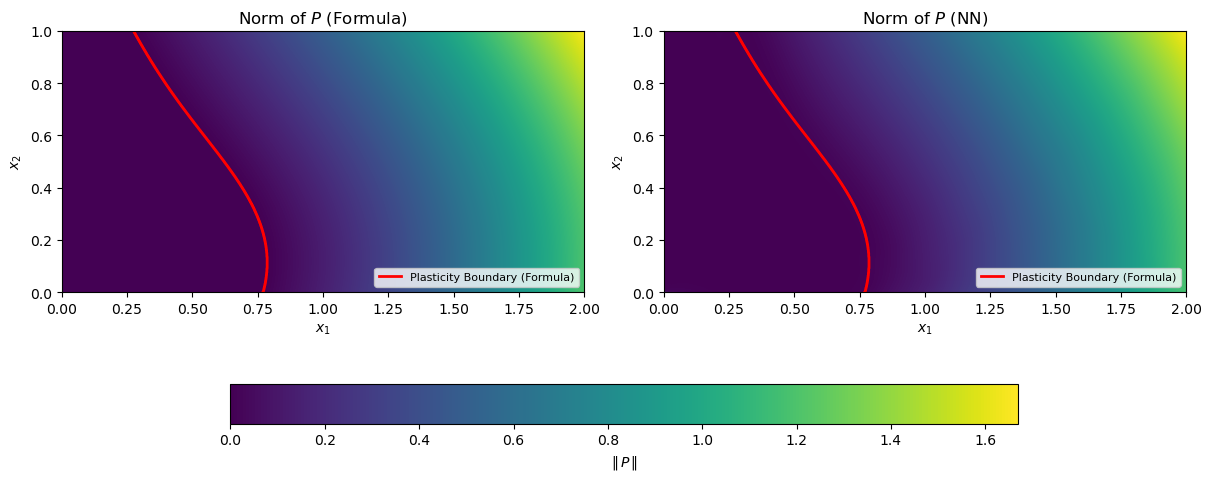

In [41]:
# Visualize real vs NN-generated P_norm
# Calculate the shared color range
vmin = min(norms_P_grid.min(), norms_P_nn_grid.min())
vmax = max(norms_P_grid.max(), norms_P_nn_grid.max())

# Enable constrained layout
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), constrained_layout=True)

# Norms from the formula
im1 = ax1.imshow(
    norms_P_grid,
    extent=(x1_min, x1_max, x2_min, x2_max),
    origin='lower',
    cmap="viridis",
    vmin=vmin,
    vmax=vmax
)
ax1.set_title("Norm of $P$ (Formula)")
ax1.set_xlabel("$x_1$")
ax1.set_ylabel("$x_2$")
ax1.plot(boundary_x1, boundary_x2, 'r-', linewidth=2, label="Plasticity Boundary (Formula)")

# Norms from the NN
im2 = ax2.imshow(
    norms_P_nn_grid,
    extent=(x1_min, x1_max, x2_min, x2_max),
    origin='lower',
    cmap="viridis",
    vmin=vmin,
    vmax=vmax
)
ax2.set_title("Norm of $P$ (NN)")
ax2.set_xlabel("$x_1$")
ax2.set_ylabel("$x_2$")
ax2.plot(boundary_x1, boundary_x2, 'r-', linewidth=2, label="Plasticity Boundary (Formula)")

# Add a legend to both subplots
ax1.legend(loc="lower right", fontsize=8)
ax2.legend(loc="lower right", fontsize=8)

# Add a common colorbar automatically
cbar = fig.colorbar(im1, ax=[ax1, ax2], orientation='horizontal', pad=0.1, shrink = 0.7)
cbar.set_label(r"$\|\,P\,\|$")

# Save the figure
#plt.savefig("../images/single-yield/P_norm_comparison_formula_vs_nn.png", format="png", dpi = 300, bbox_inches="tight")  # uncomment/comment to save/not to save
plt.show()

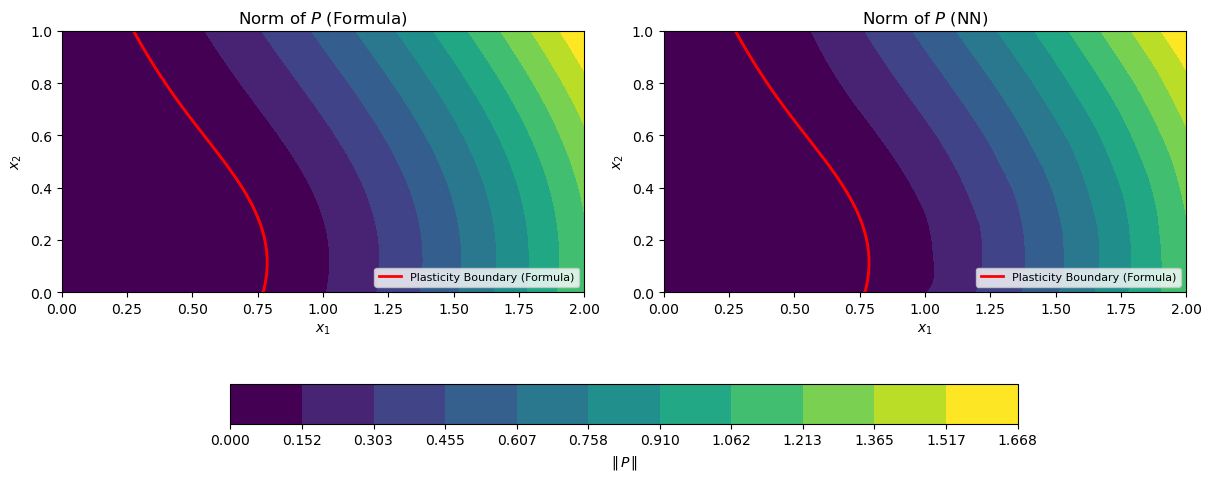

In [42]:
# Define the color map and discrete levels for visualization
vmax = max(norms_P_grid.max(), norms_P_nn_grid.max())  # Maximum value across both grids
levels = np.linspace(0, vmax, 12)  # 12 discrete color levels
cmap = "viridis"  # colormap
norm = BoundaryNorm(levels, ncolors=256, clip=True)  # Discrete color mapping

# Create figure
plt.figure(figsize=(12, 6), constrained_layout=True)

# Plot formula-based Norm of P
ax1 = plt.subplot(1, 2, 1)
im1 = ax1.imshow(
    norms_P_grid,
    extent=(x1_min, x1_max, x2_min, x2_max),
    origin="lower",
    cmap=cmap,
    norm=norm  # Apply discrete levels
)
ax1.set_title("Norm of $P$ (Formula)")
ax1.set_xlabel("$x_1$")
ax1.set_ylabel("$x_2$")
# Add boundary as red line on the NN plot
ax1.plot(boundary_x1, boundary_x2, 'r-', linewidth=2, label="Plasticity Boundary (Formula)")

# Plot neural network-based Norm of P
ax2 = plt.subplot(1, 2, 2)
im2 = ax2.imshow(
    norms_P_nn_grid,
    extent=(x1_min, x1_max, x2_min, x2_max),
    origin="lower",
    cmap=cmap,
    norm=norm  # Apply the same discrete levels
)
ax2.set_title("Norm of $P$ (NN)")
ax2.set_xlabel("$x_1$")
ax2.set_ylabel("$x_2$")
# Add the same boundary as red line on the NN plot
ax2.plot(boundary_x1, boundary_x2, 'r-', linewidth=2, label="Plasticity Boundary (Formula)")

# Add a legend to the plots
ax1.legend(loc="lower right", fontsize=8)
ax2.legend(loc="lower right", fontsize=8)

# Add a common colorbar
cbar = fig.colorbar(im1, ax=[ax1, ax2], orientation='horizontal', pad=0.1, shrink = 0.7, ticks = levels)
cbar.set_label(r"$\|\,P\,\|$")

# Save the image
#plt.savefig("../images/single-yield/P_norm_comparison_formula_vs_nn_discrete_max.png", format="png", dpi = 300, bbox_inches="tight")
plt.show()

In [43]:
# Calculate the absolute difference between formula and NN norms
delta_P = np.abs(norms_P_grid - norms_P_nn_grid)

In [44]:
print(f"Max difference: {delta_P.max():.6f}")

Max difference: 0.239307


- Calculate mean absolute and mean absolute relative error

In [45]:
# MAE: mean absolute error
mae_P = np.mean(delta_P)
print(f"MAE P: {mae_P:.4f}")

MAE P: 0.003515


In [46]:
#MARE: mean absolute relative error
eps = 1e-8  # to avoid dividing by zero
mare_P = np.mean(delta_P / (norms_P_grid + eps))
print(f"MARE P: {mare_P:.4f}")

MARE P: 91712.2525


- The mean absolute error for $P$ is quite small, but the mean absolute relative error explodes because a large fraction of the reference $P$-values are exactly zero. Division by these near-zero entries makes the relative error arbitrarily large.

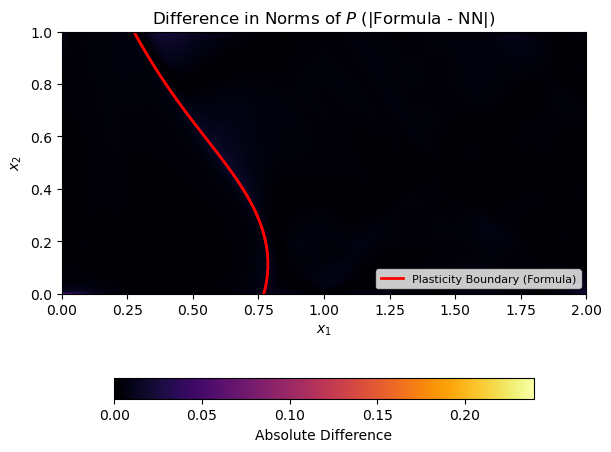

In [47]:
# Set up the plot
fig = plt.figure(figsize=(6, 5), constrained_layout=True)  # create fig

# Plot the difference
im = plt.imshow(
    delta_P,
    extent=(x1_min, x1_max, x2_min, x2_max),
    origin='lower',
    cmap="inferno",  # A good colormap for visualizing differences
    vmin=0,  # Minimum difference
    vmax=np.max(delta_P)  # Maximum difference
)

plt.title("Difference in Norms of $P$ (|Formula - NN|)")
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")

# Add plasticity boundary
plt.plot(boundary_x1, boundary_x2, 'r-', linewidth=2, label="Plasticity Boundary (Formula)")
# Add legend
plt.legend(loc="lower right", fontsize=8)

# Add a colorbar below the plot
cbar = fig.colorbar(im, orientation='horizontal', pad=0.1, shrink = 0.8)
cbar.set_label("Absolute Difference")

# Save the figure
#plt.savefig("../images/single-yield/P_norm_difference_formula_vs_nn.png", format="png", dpi = 300, bbox_inches="tight")  # uncomment/comment to save/not to save
plt.show()

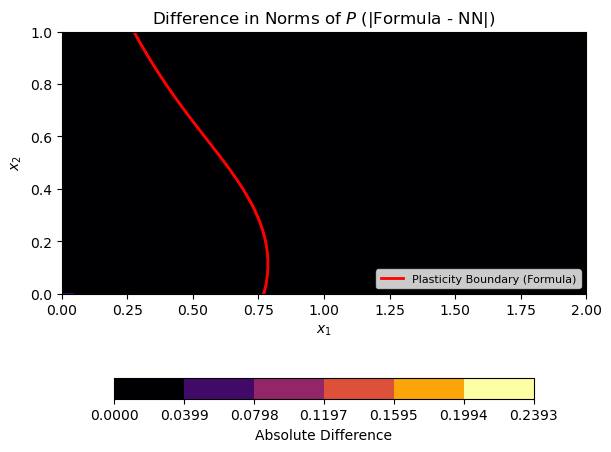

In [48]:
# Define levels for discrete colors
levels = np.linspace(0, np.max(delta_P), 7)  # discrete levels from 0 to max difference
cmap = plt.get_cmap("inferno")  # Discrete colormap
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)

# Set up the plot
plt.figure(figsize=(6, 5), constrained_layout=True)

# Plot the difference with discrete colors
im = plt.imshow(
    delta_P,
    extent=(x1_min, x1_max, x2_min, x2_max),
    origin='lower',
    cmap=cmap,  # Use discrete colormap
    norm=norm   # Apply discrete levels
)
plt.title("Difference in Norms of $P$ (|Formula - NN|)")
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")

# Add plasticity boundary
plt.plot(boundary_x1, boundary_x2, 'r-', linewidth=2, label="Plasticity Boundary (Formula)")
# Add legend
plt.legend(loc="lower right", fontsize=8)

# Add a colorbar below the plot
fig = plt.gcf()
cbar = fig.colorbar(im, orientation='horizontal', ticks = levels, pad=0.1, shrink = 0.8)
cbar.set_label("Absolute Difference")


# Save the figure
#plt.savefig("../images/single-yield/P_norm_difference_formula_vs_nn_discrete.png", format="png", dpi = 300, bbox_inches="tight")  # uncomment/comment to save/not to save
plt.show()

### Indicator Norm

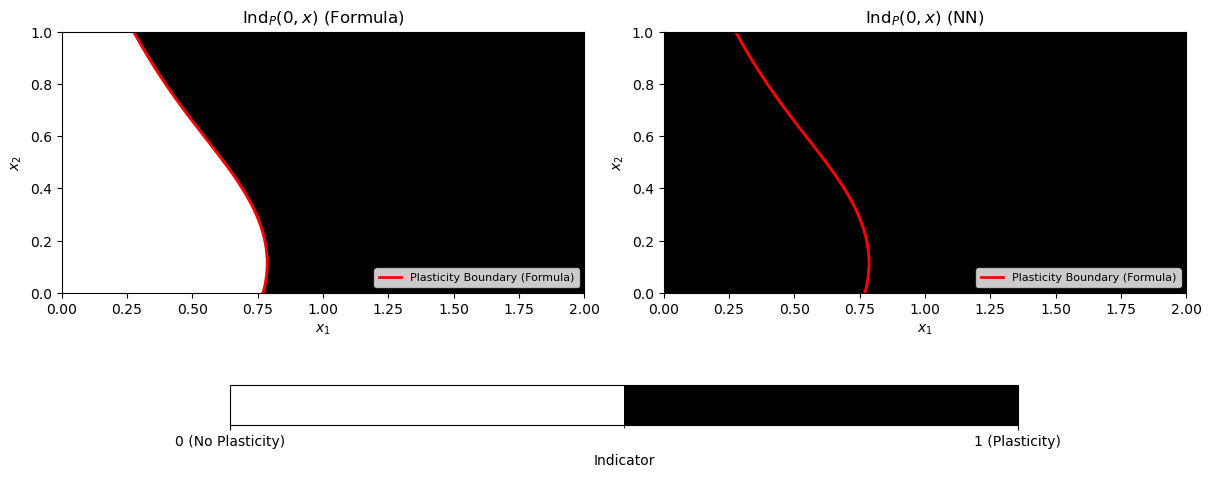

In [49]:
alpha = 0 # You can adjust the value
indicator_norm_P_nn = (norms_P_nn_grid > alpha).astype(int)
# Define a discrete colormap
cmap = mcolors.ListedColormap(["white", "black"])  # White for 0, Black for 1
bounds = [0, 0.5, 1]  # Thresholds for the color transition
norm = mcolors.BoundaryNorm(bounds, cmap.N)

# Plot the indicators with the boundary
plt.figure(figsize=(12, 6), constrained_layout=True)

# Formula-based Indicator
ax1 = plt.subplot(1, 2, 1)
im1 = ax1.imshow(
    indicator_norm_P,
    extent=(x1_min, x1_max, x2_min, x2_max),
    origin='lower',
    cmap=cmap,
    norm=norm
)
ax1.set_title(r"$\mathrm{Ind}_P(0, x)$ (Formula)")
ax1.set_xlabel("$x_1$")
ax1.set_ylabel("$x_2$")

# Add boundary as red line on the formula plot
ax1.plot(boundary_x1, boundary_x2, 'r-', linewidth=2, label="Plasticity Boundary (Formula)")

# NN-based Indicator
ax2 = plt.subplot(1, 2, 2)
im2 = ax2.imshow(
    indicator_norm_P_nn,
    extent=(x1_min, x1_max, x2_min, x2_max),
    origin='lower',
    cmap=cmap,
    norm=norm
)
ax2.set_title(rf"$\mathrm{{Ind}}_P({alpha}, x)$ (NN)")
ax2.set_xlabel("$x_1$")
ax2.set_ylabel("$x_2$")

# Add the same boundary as red line on the NN plot
ax2.plot(boundary_x1, boundary_x2, 'r-', linewidth=2, label="Plasticity Boundary (Formula)")

# Add a legend to the plots
ax1.legend(loc="lower right", fontsize=8)
ax2.legend(loc="lower right", fontsize=8)

# Add a common discrete colorbar below both subplots
cbar = fig.colorbar(im1, ax=[ax1, ax2], orientation='horizontal', pad=0.1, shrink = 0.7, ticks = [0, 1])
cbar.ax.set_xticklabels(["0 (No Plasticity)", "1 (Plasticity)"])  # Add labels to the ticks
cbar.set_label("Indicator")

# Save the figure
#plt.savefig(f"../images/single-yield/Ind_{alpha}_comparison_formula_with_boundary.png", format="png", dpi = 300, bbox_inches="tight")  # uncomment/comment to save/not to save
plt.show()

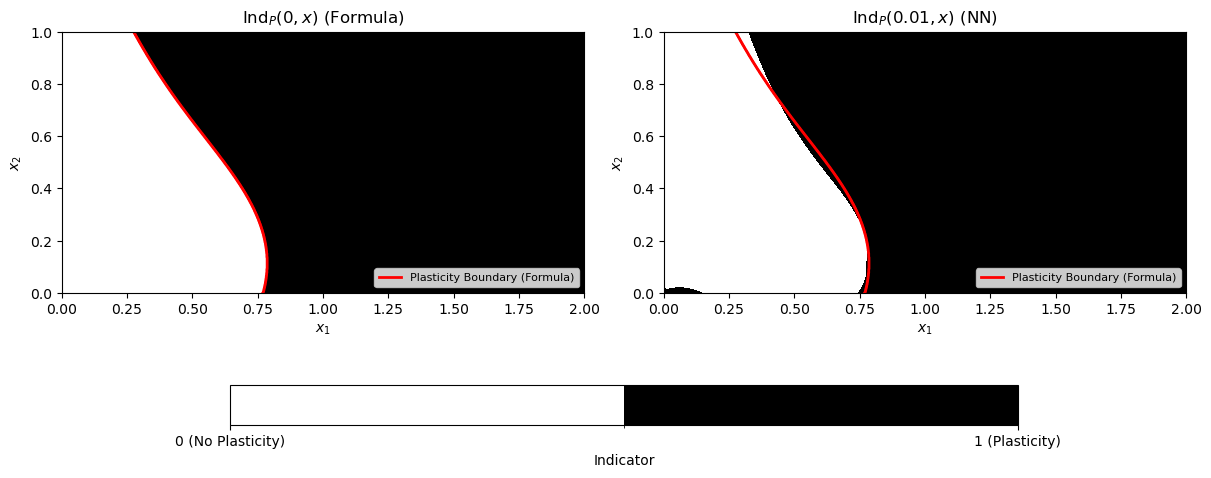

In [50]:
alpha = 0.01 # You can adjust the value
indicator_norm_P_nn = (norms_P_nn_grid > alpha).astype(int)
# Define a discrete colormap
cmap = mcolors.ListedColormap(["white", "black"])  # White for 0, Black for 1
bounds = [0, 0.5, 1]  # Thresholds for the color transition
norm = mcolors.BoundaryNorm(bounds, cmap.N)

# Plot the indicators with the boundary
plt.figure(figsize=(12, 6), constrained_layout=True)

# Formula-based Indicator
ax1 = plt.subplot(1, 2, 1)
im1 = ax1.imshow(
    indicator_norm_P,
    extent=(x1_min, x1_max, x2_min, x2_max),
    origin='lower',
    cmap=cmap,
    norm=norm
)
ax1.set_title(r"$\mathrm{Ind}_P(0, x)$ (Formula)")
ax1.set_xlabel("$x_1$")
ax1.set_ylabel("$x_2$")

# Add boundary as red line on the formula plot
ax1.plot(boundary_x1, boundary_x2, 'r-', linewidth=2, label="Plasticity Boundary (Formula)")

# NN-based Indicator
ax2 = plt.subplot(1, 2, 2)
im2 = ax2.imshow(
    indicator_norm_P_nn,
    extent=(x1_min, x1_max, x2_min, x2_max),
    origin='lower',
    cmap=cmap,
    norm=norm
)
ax2.set_title(rf"$\mathrm{{Ind}}_P({alpha}, x)$ (NN)")
ax2.set_xlabel("$x_1$")
ax2.set_ylabel("$x_2$")

# Add the same boundary as red line on the NN plot
ax2.plot(boundary_x1, boundary_x2, 'r-', linewidth=2, label="Plasticity Boundary (Formula)")

# Add a legend to the plots
ax1.legend(loc="lower right", fontsize=8)
ax2.legend(loc="lower right", fontsize=8)

# Add a common discrete colorbar below both subplots
cbar = fig.colorbar(im1, ax=[ax1, ax2], orientation='horizontal', pad=0.1, shrink = 0.7, ticks = [0, 1])
cbar.ax.set_xticklabels(["0 (No Plasticity)", "1 (Plasticity)"])  # Add labels to the ticks
cbar.set_label("Indicator")

# Save the figure
#plt.savefig(f"../images/single-yield/Ind_{alpha}_comparison_formula_with_boundary.png", format="png", dpi = 300, bbox_inches="tight")  # uncomment/comment to save/not to save
plt.show()

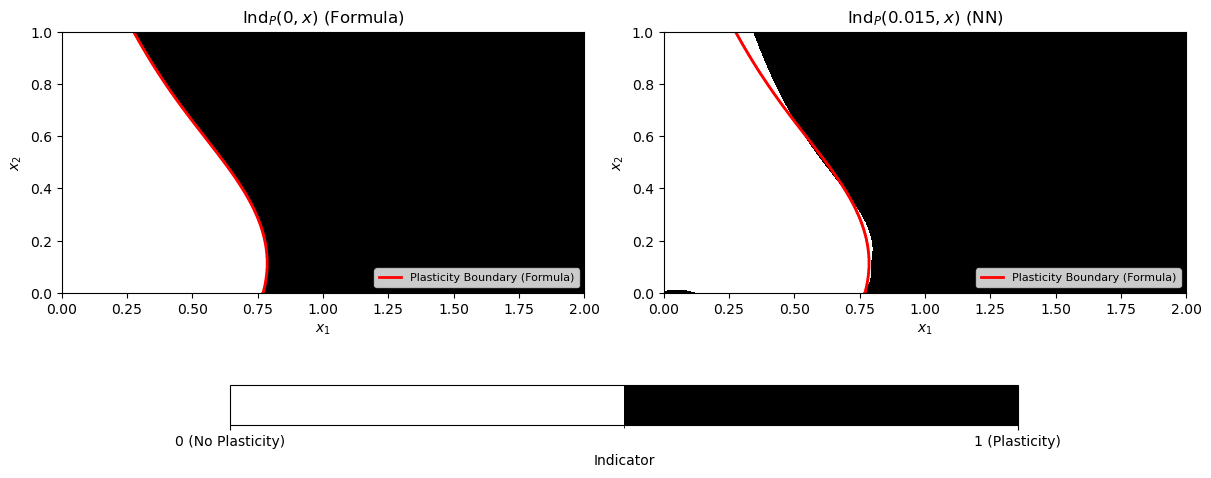

In [51]:
alpha = 0.015 # You can adjust the value
indicator_norm_P_nn = (norms_P_nn_grid > alpha).astype(int)
# Define a discrete colormap
cmap = mcolors.ListedColormap(["white", "black"])  # White for 0, Black for 1
bounds = [0, 0.5, 1]  # Thresholds for the color transition
norm = mcolors.BoundaryNorm(bounds, cmap.N)

# Plot the indicators with the boundary
plt.figure(figsize=(12, 6), constrained_layout=True)

# Formula-based Indicator
ax1 = plt.subplot(1, 2, 1)
im1 = ax1.imshow(
    indicator_norm_P,
    extent=(x1_min, x1_max, x2_min, x2_max),
    origin='lower',
    cmap=cmap,
    norm=norm
)
ax1.set_title(r"$\mathrm{Ind}_P(0, x)$ (Formula)")
ax1.set_xlabel("$x_1$")
ax1.set_ylabel("$x_2$")

# Add boundary as red line on the formula plot
ax1.plot(boundary_x1, boundary_x2, 'r-', linewidth=2, label="Plasticity Boundary (Formula)")

# NN-based Indicator
ax2 = plt.subplot(1, 2, 2)
im2 = ax2.imshow(
    indicator_norm_P_nn,
    extent=(x1_min, x1_max, x2_min, x2_max),
    origin='lower',
    cmap=cmap,
    norm=norm
)
ax2.set_title(rf"$\mathrm{{Ind}}_P({alpha}, x)$ (NN)")
ax2.set_xlabel("$x_1$")
ax2.set_ylabel("$x_2$")

# Add the same boundary as red line on the NN plot
ax2.plot(boundary_x1, boundary_x2, 'r-', linewidth=2, label="Plasticity Boundary (Formula)")

# Add a legend to the plots
ax1.legend(loc="lower right", fontsize=8)
ax2.legend(loc="lower right", fontsize=8)

# Add a common discrete colorbar below both subplots
cbar = fig.colorbar(im1, ax=[ax1, ax2], orientation='horizontal', pad=0.1, shrink = 0.7, ticks = [0, 1])
cbar.ax.set_xticklabels(["0 (No Plasticity)", "1 (Plasticity)"])  # Add labels to the ticks
cbar.set_label("Indicator")

# Save the figure
#plt.savefig(f"../images/single-yield/Ind_{alpha}_comparison_formula_with_boundary.png", format="png", dpi = 300, bbox_inches="tight")  # uncomment/comment to save/not to save
plt.show()

## Deformed grid

In [52]:
Y1 = X1 + U1
Y2 = X2 + U2
points_x = Y1.flatten()
points_y = Y2.flatten()

# Create triangulation
triangles = tri.Triangulation(points_x, points_y)

In [53]:
num_triangles = len(triangles.triangles)
print(f"Number of triangles: {num_triangles}")

Number of triangles: 3234602


In [54]:
p_flat_formula = norms_P_grid.flatten()
p_ind_flat_formula = indicator_norm_P.flatten()
p_flat_nn = norms_P_nn_grid.flatten()
p_ind_flat_nn = indicator_norm_P_nn.flatten()

In [55]:
# compute one indicator per triangle:
# e.g. if any of the triangle's vertices is plastic (==1), mark the whole triangle 1
tri_inds_formula = (p_ind_flat_formula[triangles.triangles].sum(axis=1) > 0).astype(int)
# tri_inds_nn = (p_ind_flat_nn[triangles.triangles].sum(axis=1) > 0).astype(int)
# p_flat is shape (n_points,) giving ||P|| at each vertex
# triang.triangles is shape (n_triangles, 3)
p_tri_formula = p_flat_formula[triangles.triangles].mean(axis=1)
p_tri_nn = p_flat_nn[triangles.triangles].mean(axis=1)

### Norm of P comparison

In [56]:
# Identify boundary edges where the indicator changes from 0 to 1
edges = []
for tri_idx, neighbors in enumerate(triangles.neighbors):
    for side, neighbor_idx in enumerate(neighbors):
        if neighbor_idx != -1:
            # If the indicators are different, it's on the border
            if tri_inds_formula[tri_idx] != tri_inds_formula[neighbor_idx]:
                # Get the indexes of the nodes of the current side
                i1 = triangles.triangles[tri_idx][side]
                i2 = triangles.triangles[tri_idx][(side + 1) % 3]
                edges.append((points_x[i1], points_y[i1], points_x[i2], points_y[i2]))

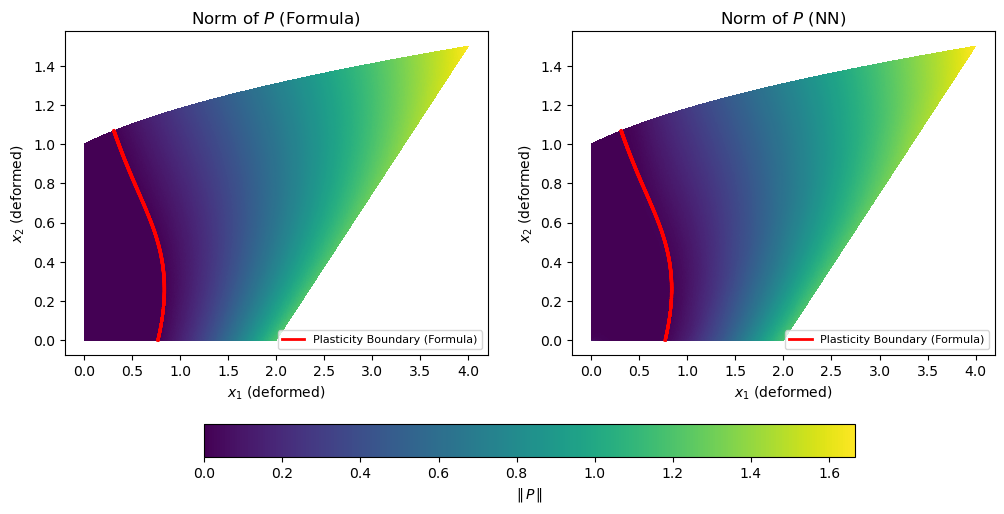

In [57]:
# Calculate shared color range
vmin = min(p_tri_formula.min(), p_tri_nn.min())
vmax = max(p_tri_formula.max(), p_tri_nn.max())

# Create figure
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))  # Use named axes

# Formula-based results
im1 = ax1.tripcolor(triangles, facecolors=p_tri_formula, cmap="viridis", vmin=vmin, vmax=vmax)
ax1.set_title("Norm of $P$ (Formula)")
ax1.set_xlabel("$x_1$ (deformed)")
ax1.set_ylabel("$x_2$ (deformed)")

# NN-based results
im2 = ax2.tripcolor(triangles, facecolors=p_tri_nn, cmap="viridis", vmin=vmin, vmax=vmax)
ax2.set_title("Norm of $P$ (NN)")
ax2.set_xlabel("$x_1$ (deformed)")
ax2.set_ylabel("$x_2$ (deformed)")

# Add plasticity boundary for both images
first_edge = True
for x1, y1, x2, y2 in edges:
    if first_edge:
        ax1.plot([x1, x2], [y1, y2], 'r-', linewidth=2, label="Plasticity Boundary (Formula)")
        ax2.plot([x1, x2], [y1, y2], 'r-', linewidth=2, label="Plasticity Boundary (Formula)")
        first_edge = False  # add label only once in first iteration
    else:
        ax1.plot([x1, x2], [y1, y2], 'r-', linewidth=2)  # no label
        ax2.plot([x1, x2], [y1, y2], 'r-', linewidth=2)  # no label

# Add legends
ax1.legend(loc="lower right", fontsize=8)
ax2.legend(loc="lower right", fontsize=8)

# Add a shared colorbar below the plots
cbar = fig.colorbar(im1, ax=[ax1, ax2], orientation='horizontal', pad=0.15, shrink = 0.7)
cbar.set_label(r"$\|\,P\,\|$")

# Adjust layout and save
#plt.savefig("../images/single-yield/P_norm_comparison_formula_vs_nn_deformed.png", format="png", dpi = 300, bbox_inches="tight")  # uncomment/comment to save/not to save
plt.show()

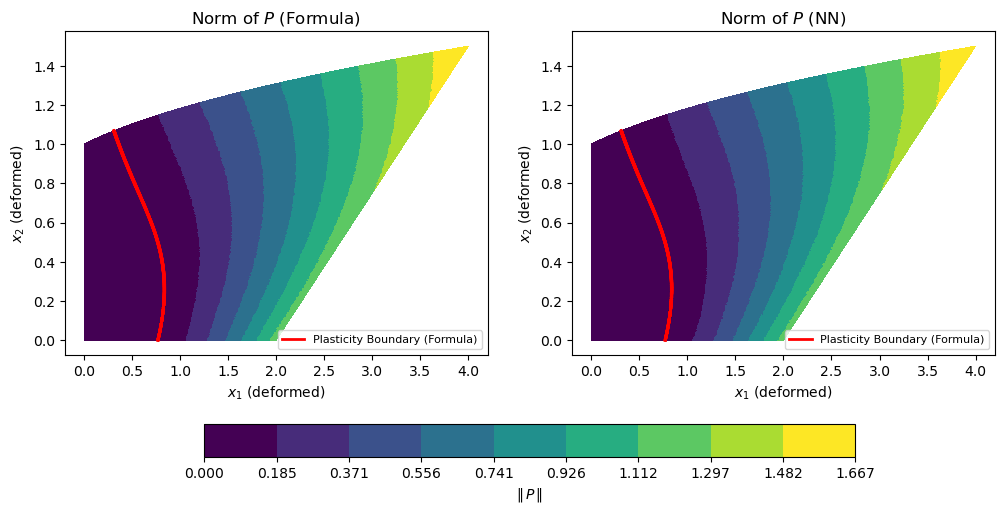

In [58]:
# Define discrete levels
levels = np.linspace(vmin, vmax, 10)  # 10 discrete levels from vmin to vmax
cmap = plt.cm.viridis  # Use the same colormap
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)

# Create figure
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))  # Use named axes

# Formula-based results with discrete levels
im1 = ax1.tripcolor(triangles, facecolors=p_tri_formula, cmap=cmap, norm=norm)
ax1.set_title("Norm of $P$ (Formula)")
ax1.set_xlabel("$x_1$ (deformed)")
ax1.set_ylabel("$x_2$ (deformed)")

# NN-based results with discrete levels
im2 = ax2.tripcolor(triangles, facecolors=p_tri_nn, cmap=cmap, norm=norm)
ax2.set_title("Norm of $P$ (NN)")
ax2.set_xlabel("$x_1$ (deformed)")
ax2.set_ylabel("$x_2$ (deformed)")

# Add plasticity boundary for both images
first_edge = True
for x1, y1, x2, y2 in edges:
    if first_edge:
        ax1.plot([x1, x2], [y1, y2], 'r-', linewidth=2, label="Plasticity Boundary (Formula)")
        ax2.plot([x1, x2], [y1, y2], 'r-', linewidth=2, label="Plasticity Boundary (Formula)")
        first_edge = False  # add label only once in first iteration
    else:
        ax1.plot([x1, x2], [y1, y2], 'r-', linewidth=2)  # no label
        ax2.plot([x1, x2], [y1, y2], 'r-', linewidth=2)  # no label

# Add legends
ax1.legend(loc="lower right", fontsize=8)
ax2.legend(loc="lower right", fontsize=8)


# Add a shared colorbar below the plots
cbar = fig.colorbar(im1, ax=[ax1, ax2], orientation='horizontal', pad=0.15, shrink = 0.7, ticks = levels)
cbar.set_label(r"$\|\,P\,\|$")

# Adjust layout and save
#plt.savefig("../images/single-yield/P_norm_comparison_formula_vs_nn_deformed_discrete.png", format="png", dpi = 300, bbox_inches="tight")
plt.show()

In [59]:
delta_P_deformed = np.abs(p_tri_nn - p_tri_formula)
print(f"Max difference: {np.max(delta_P_deformed):.6f}")

Max difference: 0.164482


- Calculate mean absolute and mean absolute relative error

In [60]:
mae_P_deformed = np.mean(delta_P_deformed)
print(f"MAE P: {mae_P_deformed:.6f}")

MAE P: 0.003505


In [61]:
mare_P_deformed = np.mean(delta_P_deformed / (p_tri_formula + eps))
print(f"MARE P: {mare_P_deformed:.6f}")

MARE P: 90503.200613


- Here the error is slightly different, because of the way the triangulation was done. The triangles took the average value of the vertex points.

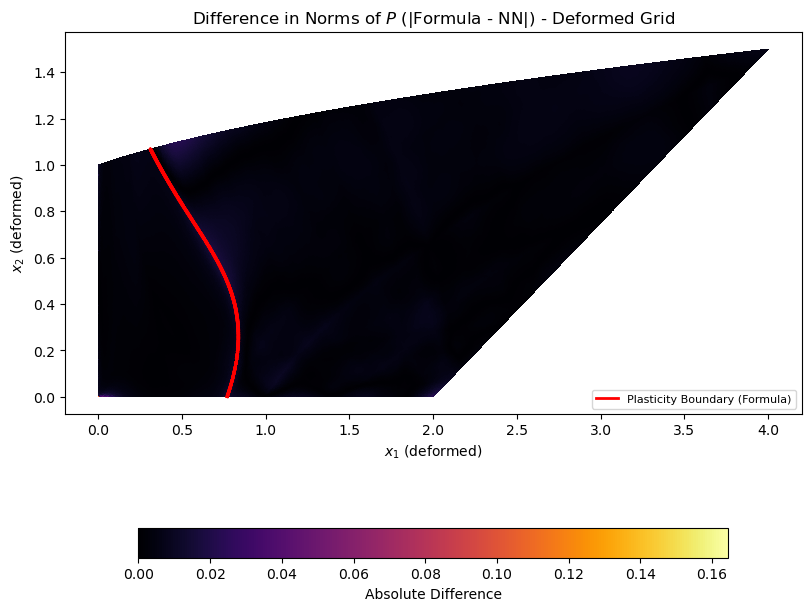

In [62]:
# Set up the plot
fig = plt.figure(figsize=(8, 6), constrained_layout=True)  # create fig

# Plot the difference on the deformed grid
im = plt.tripcolor(
    triangles,
    delta_P_deformed,
    cmap="inferno",  # colormap
    vmin=0,  # minimal difference
    vmax=np.max(delta_P_deformed)  # maximum difference
)

plt.title("Difference in Norms of $P$ (|Formula - NN|) - Deformed Grid")
plt.xlabel("$x_1$ (deformed)")
plt.ylabel("$x_2$ (deformed)")

# Add plasticity boundary
first_edge = True
for x1, y1, x2, y2 in edges:
    if first_edge:
        plt.plot([x1, x2], [y1, y2], 'r-', linewidth=2, label="Plasticity Boundary (Formula)")
        first_edge = False
    else:
        plt.plot([x1, x2], [y1, y2], 'r-', linewidth=2)

# Add legend
plt.legend(loc="lower right", fontsize=8)

# Add a colorbar below the plot
cbar = fig.colorbar(im, orientation='horizontal', pad=0.15, shrink = 0.8)
cbar.set_label("Absolute Difference")

# Save
#plt.savefig("../images/single-yield/P_norm_difference_formula_vs_nn_deformed.png", format="png", dpi = 300, bbox_inches="tight")  # uncomment/comment to save/not to save
plt.show()

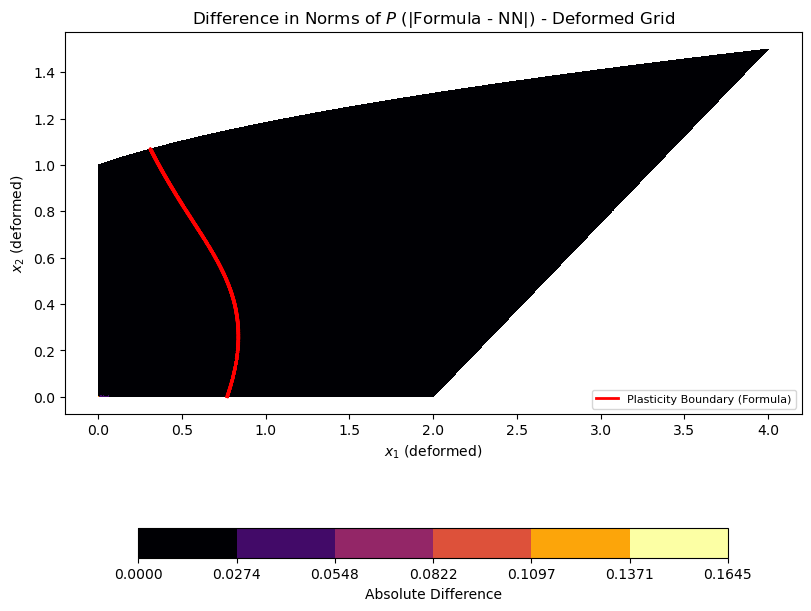

In [63]:
levels = np.linspace(0, np.max(delta_P_deformed), 7)  # discrete levels from 0 to max difference
cmap = plt.get_cmap("inferno")  # Discrete colormap
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)
# Set up the plot
fig = plt.figure(figsize=(8, 6), constrained_layout=True)  # create fig

# Plot the difference on the deformed grid
im = plt.tripcolor(
    triangles,
    delta_P_deformed,
    cmap=cmap,  # colormap
    norm = norm
)

plt.title("Difference in Norms of $P$ (|Formula - NN|) - Deformed Grid")
plt.xlabel("$x_1$ (deformed)")
plt.ylabel("$x_2$ (deformed)")

# Add plasticity boundary
first_edge = True
for x1, y1, x2, y2 in edges:
    if first_edge:
        plt.plot([x1, x2], [y1, y2], 'r-', linewidth=2, label="Plasticity Boundary (Formula)")
        first_edge = False
    else:
        plt.plot([x1, x2], [y1, y2], 'r-', linewidth=2)

# Add legend
plt.legend(loc="lower right", fontsize=8)

# Add a colorbar below the plot
cbar = fig.colorbar(im, orientation='horizontal', pad=0.15, shrink = 0.8)
cbar.set_label("Absolute Difference")

# Save
#plt.savefig("../images/single-yield/P_norm_difference_formula_vs_nn_deformed_discrete.png", format="png", dpi = 300, bbox_inches="tight")  # uncomment/comment to save/not to save
plt.show()

### Indicator norms

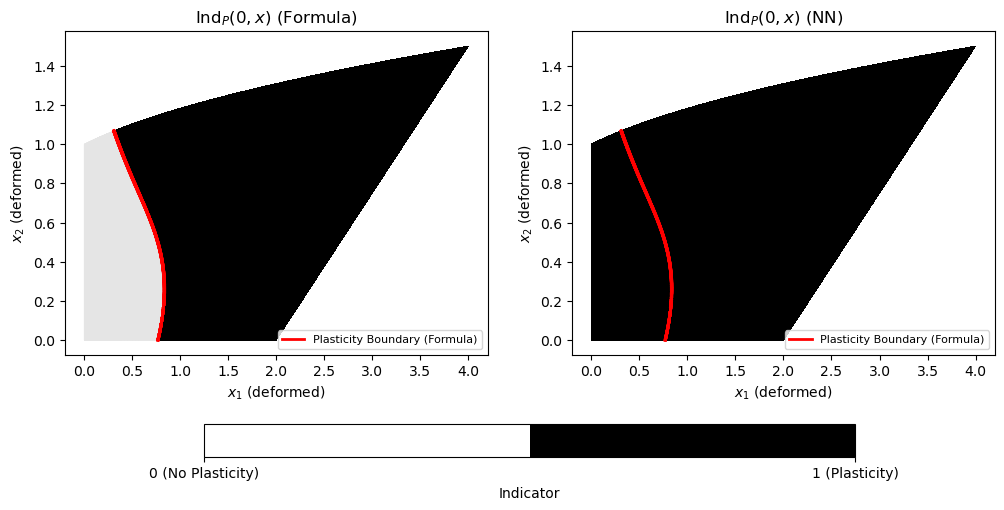

In [64]:
# Define alpha threshold for Ind(alpha)
alpha = 0  # You can adjust the value for different thresholds

# Calculate indicator norms
indicator_colors_nn = (p_tri_nn > alpha).astype(int)  # Ind(alpha) for NN

# Add a shared discrete colorbar below the plots
cmap = mcolors.ListedColormap(["white", "black"])  # Define discrete colormap
bounds = [0, 0.5, 1]  # Define boundaries for 0 and 1
norm = mcolors.BoundaryNorm(bounds, cmap.N)  # Boundary normalization

# Visualization for Indicator Norm
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))  # Use named axes

# Formula-based Indicator
im1 = ax1.tripcolor(
    triangles, facecolors=tri_inds_formula, cmap=cmap, vmin=0, vmax=1
)
ax1.triplot(
    triangles, color="black", alpha=0.1, linewidth=0.1
)  # Add triangle grid
ax1.set_title(r"$\mathrm{Ind}_P(0, x)$ (Formula)")
ax1.set_xlabel("$x_1$ (deformed)")
ax1.set_ylabel("$x_2$ (deformed)")

# NN-based Indicator
im2 = ax2.tripcolor(
    triangles, facecolors=indicator_colors_nn, cmap=cmap, vmin=0, vmax=1
)
ax2.triplot(
    triangles, color="black", alpha=0.1, linewidth=0.1
)  # Add triangle grid
ax2.set_title(rf"$\mathrm{{Ind}}_P({alpha}, x)$ (NN)")
ax2.set_xlabel("$x_1$ (deformed)")
ax2.set_ylabel("$x_2$ (deformed)")

# Add plasticity boundary for both images
first_edge = True
for x1, y1, x2, y2 in edges:
    if first_edge:
        ax1.plot([x1, x2], [y1, y2], 'r-', linewidth=2, label="Plasticity Boundary (Formula)")
        ax2.plot([x1, x2], [y1, y2], 'r-', linewidth=2, label="Plasticity Boundary (Formula)")
        first_edge = False  # add label only once in first iteration
    else:
        ax1.plot([x1, x2], [y1, y2], 'r-', linewidth=2)  # no label
        ax2.plot([x1, x2], [y1, y2], 'r-', linewidth=2)  # no label

# Add legends
ax1.legend(loc="lower right", fontsize=8)
ax2.legend(loc="lower right", fontsize=8)

# Add colorbar
cbar = fig.colorbar(im1, ax=[ax1, ax2], orientation='horizontal', pad=0.15, shrink = 0.7, ticks = [0, 1])
cbar.ax.set_xticklabels(["0 (No Plasticity)", "1 (Plasticity)"])  # Set tick labels
cbar.set_label("Indicator")

# Adjust layout and save
#plt.savefig(f"../images/single-yield/Indicator_norm_comparison_formula_vs_nn_deformed_Ind_{alpha}.png", format="png", dpi = 300, bbox_inches="tight")
plt.show()

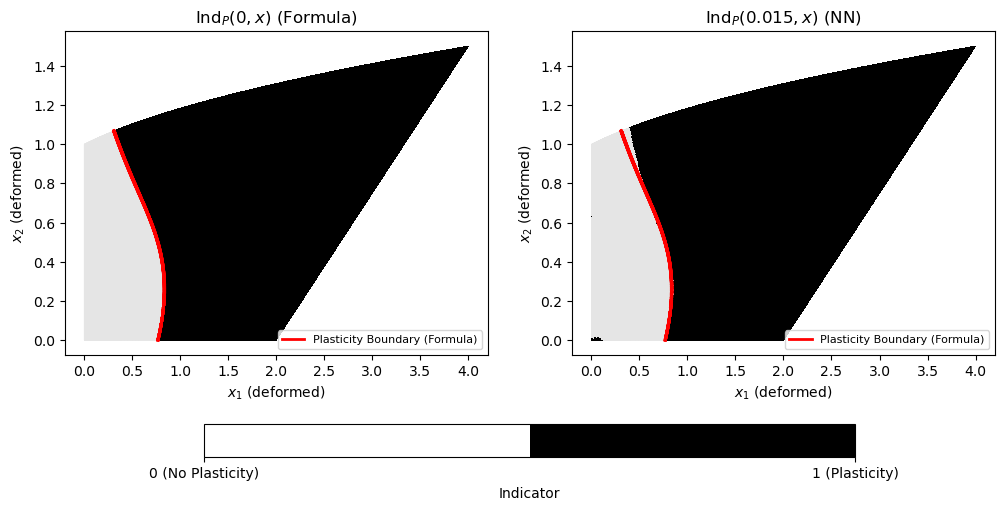

In [65]:
# Define alpha threshold for Ind(alpha)
alpha = 0.015  # You can adjust the value for different thresholds

# Calculate indicator norms
indicator_colors_nn = (p_tri_nn > alpha).astype(int)  # Ind(alpha) for NN

# Add a shared discrete colorbar below the plots
cmap = mcolors.ListedColormap(["white", "black"])  # Define discrete colormap
bounds = [0, 0.5, 1]  # Define boundaries for 0 and 1
norm = mcolors.BoundaryNorm(bounds, cmap.N)  # Boundary normalization

# Visualization for Indicator Norm
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))  # Use named axes

# Formula-based Indicator
im1 = ax1.tripcolor(
    triangles, facecolors=tri_inds_formula, cmap=cmap, vmin=0, vmax=1
)
ax1.triplot(
    triangles, color="black", alpha=0.1, linewidth=0.1
)  # Add triangle grid
ax1.set_title(r"$\mathrm{Ind}_P(0, x)$ (Formula)")
ax1.set_xlabel("$x_1$ (deformed)")
ax1.set_ylabel("$x_2$ (deformed)")

# NN-based Indicator
im2 = ax2.tripcolor(
    triangles, facecolors=indicator_colors_nn, cmap=cmap, vmin=0, vmax=1
)
ax2.triplot(
    triangles, color="black", alpha=0.1, linewidth=0.1
)  # Add triangle grid
ax2.set_title(rf"$\mathrm{{Ind}}_P({alpha}, x)$ (NN)")
ax2.set_xlabel("$x_1$ (deformed)")
ax2.set_ylabel("$x_2$ (deformed)")

# Add plasticity boundary for both images
first_edge = True
for x1, y1, x2, y2 in edges:
    if first_edge:
        ax1.plot([x1, x2], [y1, y2], 'r-', linewidth=2, label="Plasticity Boundary (Formula)")
        ax2.plot([x1, x2], [y1, y2], 'r-', linewidth=2, label="Plasticity Boundary (Formula)")
        first_edge = False  # add label only once in first iteration
    else:
        ax1.plot([x1, x2], [y1, y2], 'r-', linewidth=2)  # no label
        ax2.plot([x1, x2], [y1, y2], 'r-', linewidth=2)  # no label

# Add legends
ax1.legend(loc="lower right", fontsize=8)
ax2.legend(loc="lower right", fontsize=8)

# Add colorbar
cbar = fig.colorbar(im1, ax=[ax1, ax2], orientation='horizontal', pad=0.15, shrink = 0.7, ticks = [0, 1])
cbar.ax.set_xticklabels(["0 (No Plasticity)", "1 (Plasticity)"])  # Set tick labels
cbar.set_label("Indicator")

# Adjust layout and save
#plt.savefig(f"../images/single-yield/Indicator_norm_comparison_formula_vs_nn_deformed_Ind_{alpha}.png", format="png", dpi = 300, bbox_inches="tight")
plt.show()